#Multi-Layer Perceptron for classification/ in python

$\newcommand{\underbr}[2]{\underbrace{#1}_{\scriptscriptstyle{#2}}}$

## Objective:
We want to implement a two layers Multi-Layer Perceptron (MLP) with 1 hidden layer in Python, for a classification problem.

The output of the network is simply the output of several cascaded functions :
- Linear transformations. We note the weights of a linear transformation with $W$
- Additive biases. We note the parameters of additive biases  with $b$
- Non-linearities.

For this, we will implement:
- the forward propagation
- the computation of the cost/loss
- the backward propagation (to obtain the gradients)
- the update of the parameters

Furthermore, we define the following sizes :

- $n^{[0]}$ : number of input neurons
- $n^{[1]}$ : number of neurons in hidden layer
- $n^{[2]}$ : number of neurons in output layer
- $m$ : number of training datapoints

### Cost function

The **cost** is the average of the the **loss** over the training data. Since we are dealing with a binary classification problem, we will use the binary cross-entropy.

$$\mathcal{L} = - \left( y \log(\hat{y}) + (1-y) \log(1-\hat{y}) \right),$$

where
- the $y$ are the ground-truth labels of the data and
- the $\hat{y}$ the estimated labels (outputs of the network).

### Forward Propagation

$$
\underbrace{Z^{[1]}}_{(m, n^{[1]})} = \underbrace{X}_{(m, n^{[0]})} \underbrace{W^{[1]}}_{(n^{[0]}, n^{[1]})} + \underbrace{b^{[1]}}_{n^{[1]}} \\
\underbrace{A^{[1]}}_{(m, n^{[1]})} = g^{[1]}(Z^{[1]}) \\
\underbrace{Z^{[2]}}_{(m, n^{[2]})} = \underbrace{A^{[1]}}_{(m, n^{[1]})} \underbrace{W^{[2]}}_{(n^{[1]}, n^{[2]})} + \underbrace{b^{[2]}}_{n^{[2]}} \\
\underbrace{A^{[2]}}_{(m, n^{[2]})} = \sigma(Z^{[2]})
$$

where:
- \(g^{[1]}\) is a `ReLU` non-linear activation function (code provided).
- \(\sigma\) is a sigmoid output activation function (code provided).


### Backward propagation

The backward propagation can be calculated as

$$
\newcommand{\ddd}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\L}[0]{\mathcal{L}}
\newcommand{\l}[1]{^{[#1]}}
\newcommand{\dZdeux}[0]{ \underbr{ \ddd{\L}{Z\l2} }{ (m,n\l2)} }
\newcommand{\dWdeux}[0]{ \underbr{ \ddd{\L}{W\l2} }{ (n\l1,n\l2)} }
\newcommand{\dbdeux}[0]{ \underbr{ \ddd{\L}{b\l2} }{ (n\l2)} }
\newcommand{\dAun}[0]{ \underbr{ \ddd{\L}{A\l1} }{ (m,n\l1)} }
\newcommand{\dZun}[0]{ \underbr{ \ddd{\L}{Z\l1} }{ (m,n\l1)} }
\newcommand{\dWun}[0]{ \underbr{ \ddd{\L}{W\l1} }{ (n\l0,n\l1)} }
\newcommand{\dbun}[0]{ \underbr{ \ddd{\L}{b\l1} }{ (n\l1)} }
\\
\dZdeux = \underbr{A\l2}{(m,n\l2)} - \underbr{Y}{(m,n\l2)}  
\\
\dWdeux = \frac{1}{m} {\underbr{A\l1}{(m,n\l1)}}^{T} \dZdeux  
\\
\dbdeux = \frac{1}{m} \sum_{i=1}^{m} \dZdeux  
\\
\dAun = \dZdeux {\underbr{W\l2}{(n\l1,n\l2)}}^{T}  
\\
\dZun = \dAun \: \odot \: {g\l1}' (\underbr{Z\l1}{(m,n\l1)})  
\\
\dWun = \frac{1}{m} {\underbr{X}{(m,n^{[0]})}}^{T} \dZun  
\\
\dbun = \frac{1}{m} \sum_{i=1}^{m} \dZun
$$

Based on the previous formulae, write the corresponding backpropagation algorithm.

### Parameters update

- Implement a **first version** in which the parameters are updated using a **simple gradient descent**:

$$
\newcommand{\ddd}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\L}[0]{\mathcal{L}}
W = W - \alpha \ddd{\L}{W}
$$


- Implement a **second version** in which the parameters are updated using the **momentum method**:

$$
\newcommand{\ddd}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\L}[0]{\mathcal{L}}
V_{dW}(t) = \beta V_{dW}(t-1) + (1-\beta) \ddd{\L}{W} \\
W(t) = W(t-1) - \alpha V_{dW}(t)
$$


# Load packages

In [1]:
%matplotlib inline
import numpy as np
from sklearn import datasets
from sklearn import model_selection
import matplotlib.pyplot as plt

student = True

# Define a set of functions

In [2]:
def F_standardize(X):
    """
    standardize X, i.e. subtract mean (over data) and divide by standard-deviation (over data)

    Parameters
    ----------
    X: np.array of size (m, n_0)
        matrix containing the observation data

    Returns
    -------
    X: np.array of size (m, n_0)
        standardize version of X
    """

    X -= np.mean(X, axis=0, keepdims=True)
    X /= (np.std(X, axis=0, keepdims=True) + 1e-16)
    return X

In [3]:
def F_sigmoid(x):
    """Compute the value of the sigmoid activation function"""
    return 1 / (1 + np.exp(-x))

def F_relu(x):
    """Compute the value of the Rectified Linear Unit activation function"""
    return x * (x > 0)

def F_dRelu(x):
    """Compute the derivative of the Rectified Linear Unit activation function"""
    x[x<=0] = 0
    x[x>0] = 1
    return x


### manual implementation 

def F_computeCost(hat_y, y):
    """Compute the cost (sum of the losses)

    Parameters
    ----------
    hat_y: (m, 1)
        predicted value by the MLP
    y: (m, 1)
        ground-truth class to predict
    """
    m = y.shape[0]

    loss =  - (y*np.log(hat_y) + (1-y)*np.log(1-hat_y))
    cost = np.sum(loss) / m
    return cost

def F_computeAccuracy(hat_y, y):
    """Compute the accuracy

    Parameters
    ----------
    hat_y: (m, 1)
        predicted value by the MLP
    y: (m, 1)
        ground-truth class to predict
    """

    m = y.shape[0]
    class_y = np.copy(hat_y)
    class_y[class_y>=0.5]=1
    class_y[class_y<0.5]=0
    return np.sum(class_y==y) / m

# Load dataset and pre-process it

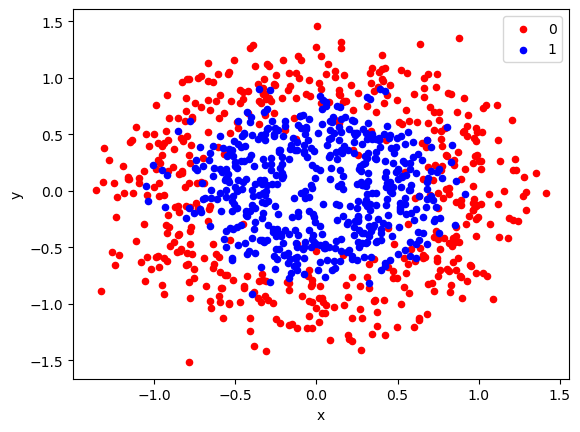

In [4]:
X, y = datasets.make_circles(n_samples=1000, noise=0.2, factor=0.5)

from pandas import DataFrame
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [5]:
print("X.shape: {}".format(X.shape))
print("y.shape: {}".format(y.shape))
print(set(y))

# X is (m, n_0)
# y is (m,)

# --- Standardize data
X = F_standardize(X)

# --- Split between training set and test set
# --- (m, n_0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

# --- Convert to proper shape: (m,) -> (m, 1)
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

# --- Convert to oneHotEncoding: (nbExamples, 1) -> (nbExamples, nbClass)
n_0 = X_train.shape[1]
n_2 = 1

print("X_train.shape: {}".format(X_train.shape))
print("X_test.shape: {}".format(X_test.shape))
print("y_train.shape: {}".format(y_train.shape))
print("y_test.shape: {}".format(y_test.shape))
print("y_train.shape: {}".format(y_train.shape))
print("y_test.shape: {}".format(y_test.shape))
print("n_0=n_in: {} n_2=n_out: {}".format(n_0, n_2))

X.shape: (1000, 2)
y.shape: (1000,)
{0, 1}
X_train.shape: (800, 2)
X_test.shape: (200, 2)
y_train.shape: (800, 1)
y_test.shape: (200, 1)
y_train.shape: (800, 1)
y_test.shape: (200, 1)
n_0=n_in: 2 n_2=n_out: 1


# Manual definition of the MLP class with forward, backward and update methods

In the code we will denote
- $\frac{\partial \mathcal{L}}{\partial W^{[1]}}$ by ``dW1``,
- $\frac{\partial \mathcal{L}}{\partial b^{[1]}}$ by ``db1``,
- $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$ by ``dW2``,
- $\frac{\partial \mathcal{L}}{\partial b^{[2]}}$ by ``db2``,
- $\frac{\partial \mathcal{L}}{\partial Z^{[1]}}$ by ``dZ1``,
- $\frac{\partial \mathcal{L}}{\partial A^{[1]}}$ by ``dA1``,
- ...

In [9]:
class C_MultiLayerPerceptron:
    """
    A class used to represent a Multi-Layer Perceptron with 1 hidden layers

    ...

    Attributes
    ----------
    W1, b1, W2, b2:
        weights and biases to be learnt
    Z1, A1, Z2, A2:
        values of the internal neurons to be used for backpropagation
    dW1, db1, dW2, db2, dZ1, dZ2:
        partial derivatives of the loss w.r.t. parameters
        example: dW1 = dLoss/dW1
    VdW1, Vdb1, VdW2, Vdb2:
        momentum terms
    do_bin0_multi1:
        set wether we solve a binary or a multi-class classification problem

    Methods
    -------
    forward_propagation

    backward_propagation

    update_parameters

    """

    W1, b1, W2, b2 = [], [], [], []
    A0, Z1, A1, Z2, A2 = [], [], [], [], []
    dW1, db1, dW2, db2 = [], [], [], []
    dZ1, dA1, dZ2 = [], [], []
    # --- for momentum
    VdW1, Vdb1, VdW2, Vdb2 = [], [], [], []

    def __init__(self, n_0, n_1, n_2):
        self.W1 = np.random.randn(n_0, n_1) * 0.01
        self.b1 = np.zeros(shape=(1, n_1))
        self.W2 = np.random.randn(n_1, n_2) * 0.01
        self.b2 = np.zeros(shape=(1, n_2))
        # --- for momentum
        self.VdW1 = np.zeros(shape=(n_0, n_1))
        self.Vdb1 = np.zeros(shape=(1, n_1))
        self.VdW2 = np.zeros(shape=(n_1, n_2))
        self.Vdb2 = np.zeros(shape=(1, n_2))
        return


    def __setattr__(self, attrName, val):
        if hasattr(self, attrName):
            self.__dict__[attrName] = val
        else:
            raise Exception("self.%s note part of the fields" % attrName)
    
    # Code forwardProp by hand

    def M_forwardPropagation(self, X):
        """Forward propagation in the MLP

        Parameters
        ----------
        X: numpy array (m, n_0)
            observation data

        Return
        ------
        hat_y: numpy array (m, 1)
            predicted value by the MLP
        """

        self.A0 = X

        self.Z1 = self.A0 @ self.W1+self.b1
        self.A1 = F_relu(self.Z1)

        self.Z2 = self.A1 @ self.W2+self.b2
        self.A2 = F_sigmoid(self.Z2)

        hat_y = self.A2

        return hat_y



    def M_backwardPropagation(self, X, y):
        """Backward propagation in the MLP

        Parameters
        ----------
        X: numpy array (m, n_0)
            observation data
        y: numpy array (m, 1)
            ground-truth class to predict

        """

        m = y.shape[0]

        

        self.dZ2 = self.A2 - y
        self.dW2 = 1/m*np.dot(np.transpose(self.A1),self.dZ2)
        self.db2 = 1/m*np.sum(self.dZ2)
        self.dA1 = np.dot(self.dZ2,np.transpose(self.W2))

        self.dZ1 = np.multiply(self.dA1,F_dRelu(self.Z1))
        self.dW1 = 1/m*np.transpose(X) @ self.dZ1
        self.db1 = 1/m*np.sum(self.dZ1)
        

        return


    def M_gradientDescent(self, alpha):
        """Update the parameters of the network using gradient descent

        Parameters
        ----------
        alpha: float scalar
            amount of update at each step of the gradient descent

        """
        
        self.W1 = self.W1 - alpha*self.dW1
        self.b1 = self.b1 - alpha*self.db1
        self.W2 = self.W2 - alpha*self.dW2
        self.b2 = self.b2  - alpha*self.db2
        

        return


    def M_momentum(self, alpha, beta):
        """Update the parameters of the network using momentum method

        Parameters
        ----------
        alpha: float scalar
            amount of update at each step of the gradient descent
        beta: float scalar
            momentum term
        """

        
        self.VdW1 = beta*self.VdW1 + (1-beta)*self.dW1
        self.W1 = self.W1 - alpha*self.VdW1

        self.Vdb1 = beta*self.Vdb1 + (1-beta)*self.db1
        self.b1 = self.b1 - alpha*self.Vdb1

        self.VdW2 = beta*self.VdW2 + (1-beta)*self.dW2
        self.W2 = self.W2 - alpha*self.VdW2

        self.Vdb2 = beta*self.Vdb2 + (1-beta)*self.db2
        self.b2 = self.b2 - alpha*self.Vdb2
        



        return

# Perform training using batch-gradiant and epochs

In [10]:
# hyper-parameters
n_1 = 10 # number of hidden neurons
nb_epoch = 5000 # number of epochs (number of iterations over full training set)
alpha=0.1 # learning rate
beta=0.9 # beta parameters for momentum


# Instantiate the class MLP with providing
# the size of the various layers (n_0=n_input, n_1=n_hidden, n_2=n_output)
myMLP = C_MultiLayerPerceptron(n_0, n_1, n_2)

train_cost, train_accuracy, test_cost, test_accuracy = [], [], [], []

# Run over epochs
for num_epoch in range(0, nb_epoch):

    # --- Forward
    hat_y_train = myMLP.M_forwardPropagation(X_train)

    # --- Store results on train
    train_cost.append( F_computeCost(hat_y_train, y_train) )
    train_accuracy.append( F_computeAccuracy(hat_y_train, y_train) )

    # --- Backward
    myMLP.M_backwardPropagation(X_train, y_train)

    # --- Update
    myMLP.M_gradientDescent(alpha)
    #myMLP.M_momentum(alpha, beta)

    # --- Store results on test
    hat_y_test = myMLP.M_forwardPropagation(X_test)
    test_cost.append( F_computeCost(hat_y_test, y_test) )
    test_accuracy.append( F_computeAccuracy(hat_y_test, y_test) )

    if (num_epoch % 500)==0:
        print("epoch: {0:d} (cost: train {1:.2f} test {2:.2f}) (accuracy: train {3:.2f} test {4:.2f})".format(num_epoch, train_cost[-1], test_cost[-1], train_accuracy[-1], test_accuracy[-1]))

epoch: 0 (cost: train 0.69 test 0.69) (accuracy: train 0.50 test 0.41)
epoch: 500 (cost: train 0.67 test 0.68) (accuracy: train 0.64 test 0.57)
epoch: 1000 (cost: train 0.45 test 0.45) (accuracy: train 0.86 test 0.84)
epoch: 1500 (cost: train 0.31 test 0.32) (accuracy: train 0.89 test 0.89)
epoch: 2000 (cost: train 0.27 test 0.30) (accuracy: train 0.90 test 0.88)
epoch: 2500 (cost: train 0.26 test 0.29) (accuracy: train 0.90 test 0.88)
epoch: 3000 (cost: train 0.26 test 0.29) (accuracy: train 0.90 test 0.89)
epoch: 3500 (cost: train 0.26 test 0.30) (accuracy: train 0.90 test 0.88)
epoch: 4000 (cost: train 0.26 test 0.30) (accuracy: train 0.90 test 0.89)
epoch: 4500 (cost: train 0.25 test 0.30) (accuracy: train 0.90 test 0.89)


## Display train/test loss and accuracy

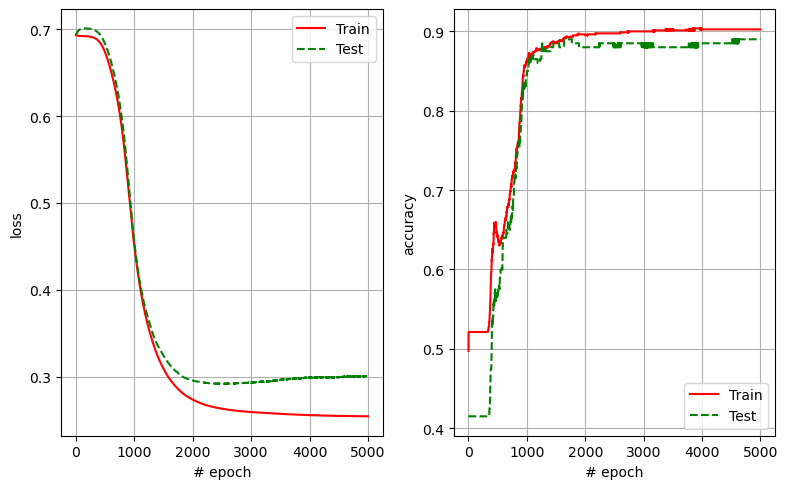

In [24]:
plt.figure(figsize=(8, 5))
plt.subplot(1,2,1)
plt.plot(train_cost,'r',label='Train')
plt.plot(test_cost, 'g--',label='Test',)
plt.xlabel('# epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r',label = 'Train')
plt.plot(test_accuracy, 'g--',label = 'Test')
plt.xlabel('# epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()